# Simple Neural Network - Binary Classification
###### Neural network from scratch

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from nn_utils import plot_decision_boundary, load_2D_dataset

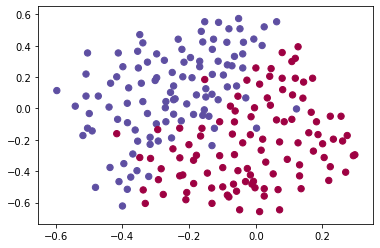

In [57]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [58]:
class nn_class():
    __PRINT_COST_INTERVAL = 1000
    
    def __init__(self, X, Y, hidden_layers, learning_rate, num_iterations, regularization=None, lambda_=0.1, initializiton=None, print_cost=False):
        np.random.seed(3)
        
        self.X = X
        self.Y = Y
        
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.print_cost = print_cost # boolean - determines if costs per interval should be printed
        self.regularization = str(regularization).upper() # type of regularization to be implemented
        self.lambda_ = lambda_ # lambda constant used for L2 regularization equation

        self.b = {}
        self.W = {}
        self.Z = {}
        self.A = { 0: X }
        self.db = {}
        self.dW = {}
        self.dA = {}
        self.costs = [] # the cost at a given interval/number of iterations, __PRINT_COST_INTERVAL
        
        self.layers = [X.shape[0]] + hidden_layers + [1] # array of layer shapes (nodes per layer), including input and output layers
        self.L = len(self.layers)-1 # number of layers
        self.m = X.shape[1] # number of training examples
               
        # initialize parameters:
        for l in range(1, self.L+1):
            self.W[l] = np.random.randn(self.layers[l], self.layers[l-1])
            self.b[l] = np.zeros((self.layers[l], 1))
            
            # scale weights:
            initializiton = str(initializiton).upper()
            
            if initializiton == 'HE':
                self.W[l] *= 2 / np.sqrt(self.layers[l-1])
            elif initializiton == 'XAVIER':
                self.W[l] *= 1 / np.sqrt(self.layers[l-1])
            else:
                self.W[l] *= 0.01

    # ########## model training functions: ##########
    def relu(self, Z):
        return np.maximum(Z, 0)
    
    def leaky_relu(self, Z):
        return np.where(Z > 0, Z, 0.01*Z)

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def relu_gradient(self, Z):
        return np.where(Z > 0, 1, 0)
    
    def leaky_relu_gradient(self, Z):
        return np.where(Z > 0, 1, 0.01)

    def sigmoid_gradient(self, Z):
        return self.sigmoid(Z) * (1 - self.sigmoid(Z))
    
    def forward_prop(self):
        for l in range(1, self.L+1):
            Z = np.dot(self.W[l], self.A[l-1]) + self.b[l]
            self.Z[l] = np.copy(Z)

            if l == self.L:
                self.A[l] = self.sigmoid(Z)
            else:
                self.A[l] = self.relu(Z)
                
        Y_hat = self.A[self.L]
        return Y_hat

    def back_prop(self):        
        for l in reversed(range(1, self.L+1)):
            if l == self.L:
                dZ = self.A[l] - self.Y
                
                # alternatively, we can compute dZ for layer L the long way -- replace the previous line with:
                # self.dA[l] = -(np.divide(self.Y, self.A[l]) - np.divide(1-self.Y, 1-self.A[l]))
                # dZ = self.dA[l] * self.sigmoid_gradient(self.Z[l]) 
            else:
                dZ = self.dA[l] * self.relu_gradient(self.Z[l])

            self.db[l] = 1.0/self.m * np.sum(dZ, axis=1, keepdims=True)
            self.dA[l-1] = np.dot(self.W[l].T, dZ)
            self.dW[l] = 1.0/self.m * np.dot(dZ, self.A[l-1].T)
            
            if self.regularization == 'L2':
                 self.dW[l] += self.lambda_/self.m * self.W[l]
            
    def update_parameters(self):
        for l in range(1, self.L+1):
            self.W[l] -= (self.learning_rate * self.dW[l])
            self.b[l] -= (self.learning_rate * self.db[l])

    def compute_cost(self, Y_hat):
        """
        Compute cost (assuming binary classification, i.e. sigmoid function in last hidden layer)
        
        N.b. cost function will change if regularization is implemented.
        """
        # cross entropy part of cost function:
        cross_entropy_cost = -1/self.m * np.nansum( (self.Y*np.log(Y_hat)) + ((1-self.Y) * np.log(1-Y_hat)) )
        cross_entropy_cost = np.squeeze(cross_entropy_cost)
        
        if self.regularization == 'L2':
            L2_regularization_cost = 1/self.m * self.lambda_/2 * np.sum([np.sum(np.square(self.W[l])) for l in range(1, self.L+1)])
            cost = cross_entropy_cost + L2_regularization_cost
        else:
            cost = cross_entropy_cost

        return cost
    
    def train(self):
        """
        Trains the model after initialization.
        """
        self.costs = []
        
        for i in range(1, self.num_iterations+1):
            Y_hat = self.forward_prop()
            gradients = self.back_prop()

            if i % self.__PRINT_COST_INTERVAL == 0:
                cost = self.compute_cost(Y_hat)
                self.costs.append(cost)
                
                # we only want to print cost during training for debugging purposes:
                if self.print_cost:
                    print('cost at %s iteration: %s' % (i, cost))

            self.update_parameters()
    
    # ########## public functions: ##########
    def plot_cost(self):
        """ 
        Plots training costs.
        
        Used for debugging training algorithm and hyperparameters.
        """
        
        plt.plot(self.costs)
        plt.title('Cost per Iteration')
        plt.xlabel('Iteration (x%s)' % self.__PRINT_COST_INTERVAL)
        plt.ylabel('Cost')
        plt.show()
    
    def predict(self, X):
        """
        Predict (binary classify)
        """
        self.A[0] = X
        self.m = X.shape[1]
        
        Y_hat = self.forward_prop()
        
        predictions = np.where(Y_hat > 0.5, 1, 0)
        return predictions
    
    def print_training_accuracy(self, X, Y):
        """
        Prints the accuracy of train/test sets.
        """
        predictions = self.predict(X)
        
        accuracy = np.mean(np.int8(predictions == Y))
        print('Accuracy: %s%%' % accuracy)
        

In [59]:
########## main: ##########
# hyper parameters:
train_hidden_layers = [20, 3]
train_learning_rate = 0.3
train_num_iterations = 100000

new_model = nn_class(train_X, train_Y, train_hidden_layers, train_learning_rate, train_num_iterations, regularization="L2", initializiton='xavier', print_cost=False)

In [60]:
new_model.train()

In [61]:
print('----- Training set: -----')
new_model.print_training_accuracy(train_X, train_Y)
print('----- Test set: -----')
new_model.print_training_accuracy(test_X, test_Y)

----- Training set: -----
Accuracy: 0.9383886255924171%
----- Test set: -----
Accuracy: 0.94%


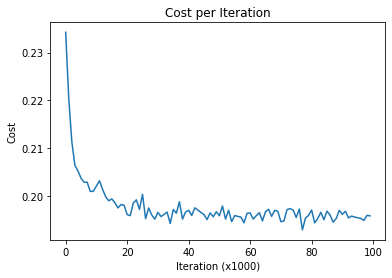

In [62]:
new_model.plot_cost()

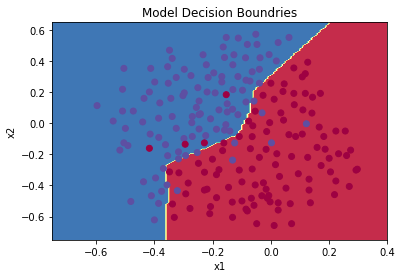

In [63]:
# plot decision boundary after training:
plt.title("Model Decision Boundaries")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: new_model.predict(x.T), train_X, np.squeeze(train_Y))